In [26]:
import rasterio as rio
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
from dateutil.relativedelta import relativedelta
from calendar import monthrange
import geopy.distance
import xarray as xr
import pandas as pd
import geopandas as gpd
import shapely.geometry
import shapely.ops
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

dataDirDiscovery = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'

In [23]:
sacksMaizeNc = xr.open_dataset('%s/sacks/Maize.crop.calendar.fill.nc'%dataDirDiscovery)
sacksStart = sacksMaizeNc['plant'].values + 1
sacksStart = np.roll(sacksStart, -int(sacksStart.shape[1]/2), axis=1)
sacksStart[sacksStart < 0] = np.nan
sacksEnd = sacksMaizeNc['harvest'].values + 1
sacksEnd = np.roll(sacksEnd, -int(sacksEnd.shape[1]/2), axis=1)
sacksEnd[sacksEnd < 0] = np.nan

sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

In [5]:
rsus=xr.open_mfdataset('/dartfs-hpc/rc/lab/C/CMIG/CMIP6/download-rad/ssp370/rsus_Amon_NorESM2-LM_*.nc')
rsds=xr.open_mfdataset('/dartfs-hpc/rc/lab/C/CMIG/CMIP6/download-rad/ssp370/rsds_Amon_NorESM2-LM_*.nc')
rlus=xr.open_mfdataset('/dartfs-hpc/rc/lab/C/CMIG/CMIP6/download-rad/ssp370/rlus_Amon_NorESM2-LM_*.nc')
rlds=xr.open_mfdataset('/dartfs-hpc/rc/lab/C/CMIG/CMIP6/download-rad/ssp370/rlds_Amon_NorESM2-LM_*.nc')

In [27]:
rnet = rsus.rsus + rsds.rsds + rlus.rlus + rlds.rlds
rnet.load()

<xarray.DataArray (time: 1032, lat: 96, lon: 144)>
array([[[1037.8032 , 1037.5134 , 1037.4805 , ..., 1037.9019 ,
         1037.8903 , 1037.8704 ],
        [1048.5339 , 1048.8636 , 1047.4875 , ..., 1050.4525 ,
         1049.3544 , 1048.4867 ],
        [1061.269  , 1059.9738 , 1059.1536 , ..., 1068.2609 ,
         1067.0345 , 1064.8597 ],
        ...,
        [ 357.0874 ,  357.63354,  358.02036, ...,  354.1217 ,
          354.84082,  355.885  ],
        [ 343.88684,  344.2879 ,  344.95844, ...,  343.26746,
          343.20807,  343.35107],
        [ 335.67087,  335.73804,  335.85803, ...,  335.72986,
          335.71442,  335.69196]],

       [[ 710.1791 ,  709.8906 ,  709.84045, ...,  710.2683 ,
          710.26   ,  710.23444],
        [ 710.8964 ,  709.9575 ,  709.85785, ...,  713.0654 ,
          712.4137 ,  712.3251 ],
        [ 713.27527,  711.52136,  709.774  , ...,  718.4561 ,
          717.872  ,  715.98047],
        ...,
        [ 406.76202,  405.99384,  405.30606, ...,  404.04517,
          404.75354,  405.96527],
        [ 394.214  ,  393.69986,  392.23477, ...,  396.12817,
          395.57397,  394.91095],
        [ 384.1829 ,  384.06076,  383.93378, ...,  384.24728,
          384.232  ,  384.21692]],

       [[ 304.62503,  304.33813,  304.2806 , ...,  304.72318,
          304.71252,  304.68954],
        [ 299.67392,  298.72232,  298.13834, ...,  301.28143,
          300.93835,  300.18515],
        [ 315.13458,  313.76028,  312.397  , ...,  319.10315,
          318.36972,  316.6245 ],
        ...,
        [ 429.95758,  431.28534,  432.3769 , ...,  423.94595,
          426.46722,  428.60355],
        [ 427.69003,  428.21008,  428.7497 , ...,  427.67554,
          427.73303,  427.65674],
        [ 430.76004,  430.77765,  430.80414, ...,  430.75177,
          430.75446,  430.7586 ]],

       ...,

       [[ 506.5542 ,  506.2475 ,  506.18646, ...,  506.66113,
          506.64975,  506.62515],
        [ 502.42755,  501.35696,  500.91464, ...,  504.5854 ,
          503.59006,  503.0694 ],
        [ 509.6203 ,  508.85208,  508.16425, ...,  512.92896,
          512.10406,  510.9392 ],
        ...,
        [ 582.14044,  583.74976,  584.4956 , ...,  582.69617,
          582.563  ,  582.084  ],
        [ 586.4354 ,  586.8071 ,  587.5255 , ...,  585.69403,
          585.85315,  586.12573],
        [ 591.40735,  591.41113,  591.3755 , ...,  591.38446,
          591.4059 ,  591.3844 ]],

       [[ 922.9255 ,  922.61096,  922.5483 , ...,  923.03253,
          923.02435,  922.9955 ],
        [ 925.4591 ,  924.9214 ,  924.6066 , ...,  924.9226 ,
          925.2502 ,  925.7046 ],
        [ 927.32654,  927.82733,  928.07697, ...,  925.38904,
          925.7767 ,  926.64624],
        ...,
        [ 571.36554,  573.375  ,  576.4738 , ...,  569.80896,
          570.06586,  570.62366],
        [ 565.3786 ,  564.1714 ,  562.6432 , ...,  567.6964 ,
          566.91284,  566.287  ],
        [ 563.7582 ,  563.62964,  563.3646 , ...,  563.79224,
          563.7835 ,  563.7692 ]],

       [[1159.642  , 1159.3163 , 1159.2639 , ..., 1159.7361 ,
         1159.7225 , 1159.6926 ],
        [1148.127  , 1147.5928 , 1148.0348 , ..., 1152.7288 ,
         1150.9294 , 1149.6271 ],
        [1147.414  , 1150.3093 , 1151.2045 , ..., 1147.6129 ,
         1147.1149 , 1147.1233 ],
        ...,
        [ 436.09283,  435.04633,  434.49158, ...,  436.0406 ,
          435.9341 ,  435.93454],
        [ 428.89017,  428.65106,  428.3425 , ...,  429.95447,
          429.4704 ,  429.13095],
        [ 450.49277,  450.20544,  449.72052, ...,  450.43796,
          450.44913,  450.46814]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00

In [59]:

NFutureYears = 2050-2015+1
growSeasonRnet = np.full([sacksLat.shape[0], sacksLon.shape[0], NFutureYears], np.nan)

for i, xlat in enumerate(sacksLat):
    
    if i%10==0:
        print('%.0f%%...'%(i/len(sacksLat)*100))
    
    if xlat < 20 or xlat > 50: continue
    
    for k, ylon in enumerate(sacksLon):
        
        if ylon < 200 or ylon > 320: continue
        
        if np.isnan(sacksStart[i,k]) or np.isnan(sacksEnd[i,k]): continue
        
        startMonth = datetime.datetime.strptime('%d'%(sacksStart[i,k]), '%j').date().month
        endMonth = datetime.datetime.strptime('%d'%(sacksEnd[i,k]), '%j').date().month
        
        curRnet = rnet.sel(lat=xlat, lon=ylon, method='nearest')
        
        for y, year in enumerate(range(2015, 2050+1)):
            if  startMonth > endMonth:
                curGrowSeasonRnet = curRnet.sel(time=slice('%d-%02d'%(year-1, startMonth), '%d-%02d'%(year, endMonth))).mean()
            else:
                curGrowSeasonRnet = curRnet.sel(time=slice('%d-%02d'%(year, startMonth), '%d-%02d'%(year, endMonth))).mean()
            growSeasonRnet[i,k,y] = float(curGrowSeasonRnet.values)
        
            

0%...
3%...
6%...
8%...
11%...
14%...
17%...
19%...
22%...
25%...
28%...
31%...
33%...
36%...
39%...
42%...
44%...
47%...
50%...
53%...
56%...
58%...
61%...
64%...
67%...
69%...
72%...
75%...
78%...
81%...
83%...
86%...
89%...
92%...
94%...
97%...


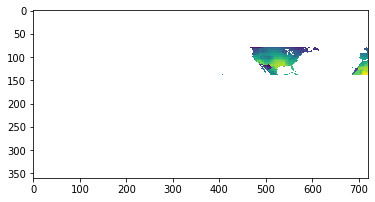

In [60]:
plt.imshow(growSeasonRnet[:,:,0])